In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h3
import xgboost as xgb
import seaborn as sns
import h3

### 用維吉尼亞市的OHCA數據訓練XGB模型

In [2]:
h3_l7_df_VB = pd.read_csv('h3_l7_df_new.csv')
h3_l7_df_VB.drop(columns=['commercial;yes'], inplace=True)

train_index=[]
test_index=[]
for i in range(0,h3_l7_df_VB.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df_VB.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df_VB.iloc[train_index]
test_h3_l7_df = h3_l7_df_VB.iloc[test_index]

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df_VB.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())


# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

# 分离特征和标签
X = spatial_data[:, :-1]  # 特征
Y = spatial_data[:, -1]   # 标签（OHCA）

X_train_reguli = train_spatial_data[:, :-1] 
y_train_reguli = train_spatial_data[:, -1] 
X_test_reguli = test_spatial_data[:, :-1] 
y_test_reguli = test_spatial_data[:, -1] 

# 定義XGBoost模型並指定參數
best_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=277,
    early_stopping_rounds=10,
    # 以下是您指定的參數值，請根據需要修改這些值
    max_depth=3,               # 樹的最大深度
    learning_rate=0.2,         # 學習率
    n_estimators=100,          # 樹的數量
    subsample=0.7,            # 每棵樹隨機採樣的比例 0.7
    colsample_bytree=0.7,      # 每棵樹使用的特徵比例 0.7
    gamma=0,                # 控制節點分裂的最小增益
    reg_alpha=0.1,            # L1正則化強度 0
    reg_lambda=1,           # L2正則化強度
    min_child_weight=3        # 每個葉子節點的最小樣本權重
)

# 訓練模型
best_xgb_model.fit(
    X_train_reguli, y_train_reguli,
    eval_set=[(X_test_reguli, y_test_reguli)],  # 提供測試集進行早停監控
    verbose=True
)

# 1. 先正確定義統計量
ohca_min = h3_l7_df_VB.ohca.min()
ohca_max = h3_l7_df_VB.ohca.max()
ohca_range = ohca_max - ohca_min  # 這是 (Max - Min)

# 2. 預測訓練集結果並正確還原
# 公式： 預測值 * Range + Min
y_head_train_norm = best_xgb_model.predict(X_train_reguli)
y_head_train = y_head_train_norm * ohca_range + ohca_min

# 還原真實訓練集標籤 (用來算誤差)
y_train = y_train_reguli * ohca_range + ohca_min

# 3. 預測測試集結果並正確還原
y_head_test_norm = best_xgb_model.predict(X_test_reguli)
y_head_test = y_head_test_norm * ohca_range + ohca_min

# 還原真實測試集標籤
y_test = y_test_reguli * ohca_range + ohca_min


#評估成效
train_mae = np.abs(y_head_train-y_train)
train_ans_mae = train_mae.sum()/train_mae.shape[0]
print('MAE of train set= ',train_ans_mae)
# 計算殘差變異
train_ss_residual = np.sum((y_train - y_head_train) ** 2)
# 計算總變異量
train_ss_total = np.sum((y_train - np.mean(y_train)) ** 2)
# 計算 R²
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

test_mae = np.abs(y_head_test-y_test)
test_ans_mae = test_mae.sum()/test_mae.shape[0]
print('MAE of test set= ',test_ans_mae)
# 計算殘差變異
test_ss_residual = np.sum((y_test - y_head_test) ** 2)
# 計算總變異量
test_ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
# 計算 R²
test_r_squared = 1 - (test_ss_residual / test_ss_total)
print("R² of test set= ", test_r_squared)

[0]	validation_0-rmse:0.24953
[1]	validation_0-rmse:0.22717
[2]	validation_0-rmse:0.21675
[3]	validation_0-rmse:0.19437
[4]	validation_0-rmse:0.17980
[5]	validation_0-rmse:0.17177
[6]	validation_0-rmse:0.16906
[7]	validation_0-rmse:0.16359
[8]	validation_0-rmse:0.15430
[9]	validation_0-rmse:0.14877
[10]	validation_0-rmse:0.14466
[11]	validation_0-rmse:0.14188
[12]	validation_0-rmse:0.14336
[13]	validation_0-rmse:0.14145
[14]	validation_0-rmse:0.13830
[15]	validation_0-rmse:0.13515
[16]	validation_0-rmse:0.13363
[17]	validation_0-rmse:0.13014
[18]	validation_0-rmse:0.12816
[19]	validation_0-rmse:0.12567
[20]	validation_0-rmse:0.12576
[21]	validation_0-rmse:0.12480
[22]	validation_0-rmse:0.12508
[23]	validation_0-rmse:0.12501
[24]	validation_0-rmse:0.12522
[25]	validation_0-rmse:0.12447
[26]	validation_0-rmse:0.12380
[27]	validation_0-rmse:0.12462
[28]	validation_0-rmse:0.12306
[29]	validation_0-rmse:0.12252
[30]	validation_0-rmse:0.12137
[31]	validation_0-rmse:0.12029
[32]	validation_0-

### XGB with 宜興市 dataset

In [3]:
import pandas as pd
import numpy as np

h3_l7_df_yixing = pd.read_csv('h3_l7_df_yixing.csv')
h3_l7_df_yixing

yixing_data = h3_l7_df_yixing.copy()

feature_cols = [col for col in h3_spatial_data.columns if col != 'ohca']

# 取得訓練集的 Min 和 Max (只針對特徵欄位)
train_min_vec = h3_spatial_data[feature_cols].min()
train_max_vec = h3_spatial_data[feature_cols].max()

X_yixing = yixing_data[feature_cols]

# 使用「訓練集」的 min/max 進行正規化公式： (x - min) / (max - min)
X_yixing_normalized = (X_yixing - train_min_vec) / (train_max_vec - train_min_vec)

# 轉換為模型需要的 numpy array 格式 (float64)
X_yixing_input = np.array(X_yixing_normalized).astype(np.float64)

# ---------------------------------------------------------
# 4. 進行預測
# ---------------------------------------------------------
# 使用訓練好的模型進行預測
y_pred_yixing_norm = best_xgb_model.predict(X_yixing_input)

# ---------------------------------------------------------
# 5. 反正規化 (將預測結果還原回真實數值)
# ---------------------------------------------------------
# 根據 Min-Max Normalization 的標準還原公式： y = y_norm * (max - min) + min
# 必須使用訓練集 h3_l7_df_VB 的 ohca 統計量

ohca_min = h3_l7_df_VB['ohca'].min()
ohca_max = h3_l7_df_VB['ohca'].max()
ohca_range = ohca_max - ohca_min

# 計算最終預測值
# 注意：這裡修正了您原本代碼中可能存在的公式疑慮，這是標準還原法
y_pred_yixing_final = y_pred_yixing_norm * ohca_range + ohca_min

# ---------------------------------------------------------
# 6. 整理結果
# ---------------------------------------------------------
# 將預測結果與原本的 ID 結合 (如果需要輸出的話)
result_df = pd.DataFrame({
    'id': h3_l7_df_yixing['id'],
    'predicted_ohca': y_pred_yixing_final
})

print("預測完成！前 5 筆預測結果：")
print(result_df.head(55))

預測完成！前 5 筆預測結果：
                 id  predicted_ohca
0   87309e000ffffff        0.425999
1   87309e001ffffff        0.425999
2   87309e002ffffff        0.406754
3   87309e003ffffff        0.406754
4   87309e004ffffff        8.149294
5   87309e005ffffff        0.425999
6   87309e006ffffff        0.406754
7   87309e008ffffff        5.376844
8   87309e009ffffff        5.376844
9   87309e00bffffff        5.376844
10  87309e00cffffff        0.425999
11  87309e00dffffff        0.406754
12  87309e00effffff        5.376844
13  87309e010ffffff        0.425999
14  87309e011ffffff        0.406754
15  87309e012ffffff        5.357600
16  87309e013ffffff        5.350233
17  87309e014ffffff        6.213337
18  87309e015ffffff        5.357600
19  87309e016ffffff        8.846533
20  87309e018ffffff        5.085549
21  87309e019ffffff        0.406754
22  87309e01bffffff        0.406754
23  87309e01cffffff        0.425999
24  87309e01dffffff        5.376844
25  87309e01effffff        5.376844
26  87309e02

### 宜興市預測結果

繪圖數據範圍: Min=0.1347, Max=13.2613


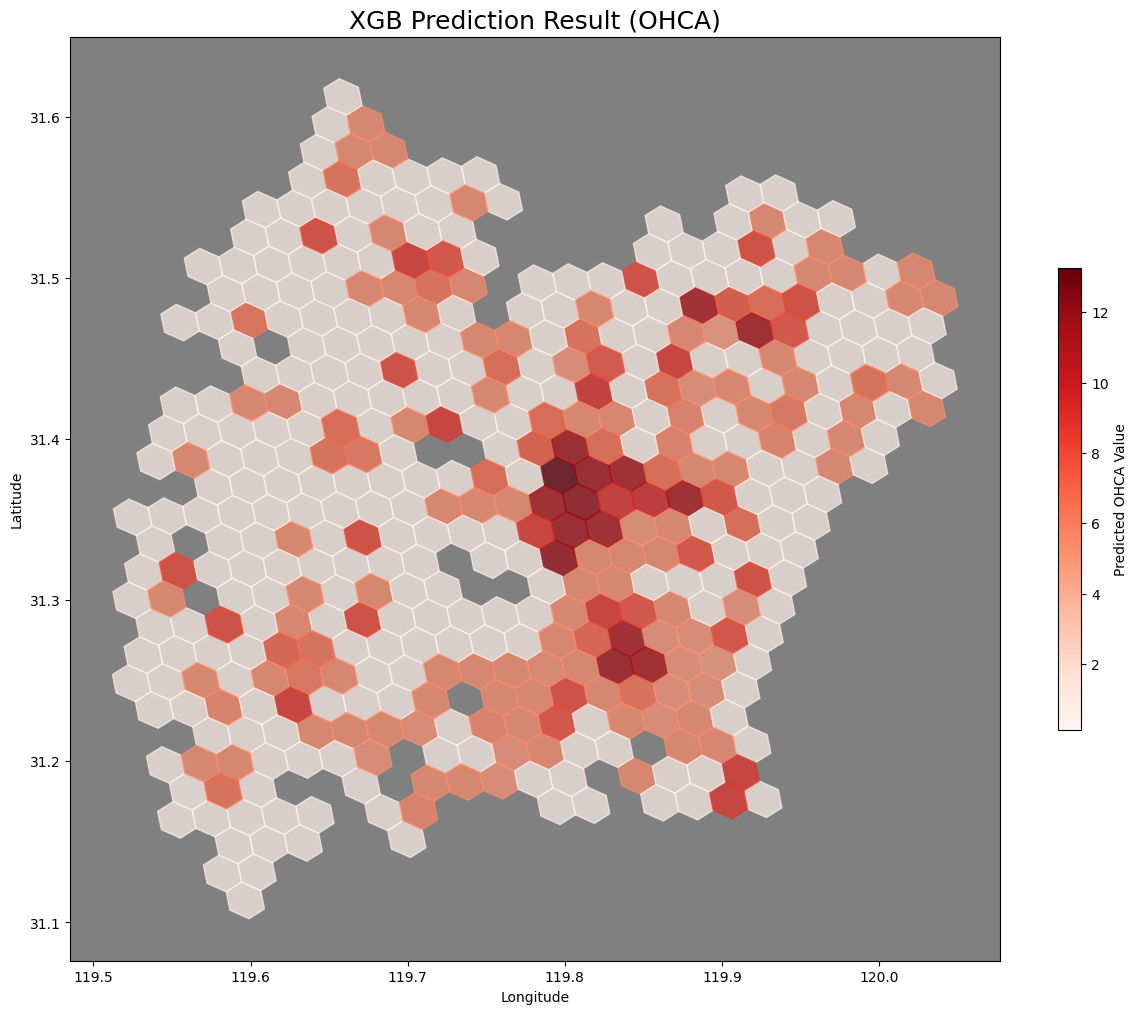

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import Polygon
import h3

# ---------------------------------------------------------
# Step 1: 準備繪圖資料
# ---------------------------------------------------------
# 將原本的 ID 與 剛剛算出來的預測值 (y_pred_yixing_final) 結合
visualization_df = pd.DataFrame({
    'id': h3_l7_df_yixing['id'],      # 確保這裡是來自 yixing 資料集的 ID
    'pred_value': y_pred_yixing_final # 這是剛剛算出來的預測結果
})

# 定義顏色範圍 (vmin, vmax)
# 使用這次預測結果的最大最小值，讓顏色分布最明顯
vmin_val = visualization_df['pred_value'].min()
vmax_val = visualization_df['pred_value'].max()

print(f"繪圖數據範圍: Min={vmin_val:.4f}, Max={vmax_val:.4f}")

# ---------------------------------------------------------
# Step 2: 開始繪圖
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 12))

# 建立顏色映射 (Normalize)
color_norm = mcolors.Normalize(vmin=vmin_val, vmax=vmax_val)

# Step 3: 繪製每個網格
# 注意：如果數據量很大，這個迴圈可能會跑一點時間
for index, row in visualization_df.iterrows():
    # 將 H3 索引轉換為多邊形邊界 (geo_json=True 確保輸出格式為 (lng, lat))
    try:
        boundary = h3.h3_to_geo_boundary(row['id'], geo_json=True)
        polygon = Polygon(boundary)
        
        # 根據預測值決定顏色
        color = plt.cm.Reds(color_norm(row['pred_value']))
        
        # 畫在圖上
        ax.fill(*zip(*polygon.exterior.coords), color=color, alpha=0.7)
    except Exception as e:
        print(f"Error plotting H3 ID {row['id']}: {e}")
        continue

# Step 4: 創建並顯示顏色條
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=color_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('Predicted OHCA Value') # 設定 Colorbar 標籤

# Step 5: 設定地圖細節
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('XGB Prediction Result (OHCA)', fontsize=18) # 設定標題
ax.set_facecolor('grey') # 設定背景色，讓紅色更明顯

# 自動調整顯示範圍以適應所有多邊形
ax.autoscale_view()

# 顯示地圖
plt.show()

# 如果想存檔，可以取消下面這行的註解
# fig.savefig('Prediction_Result_yixing.png', dpi=300)

### 宜興市可解釋分析

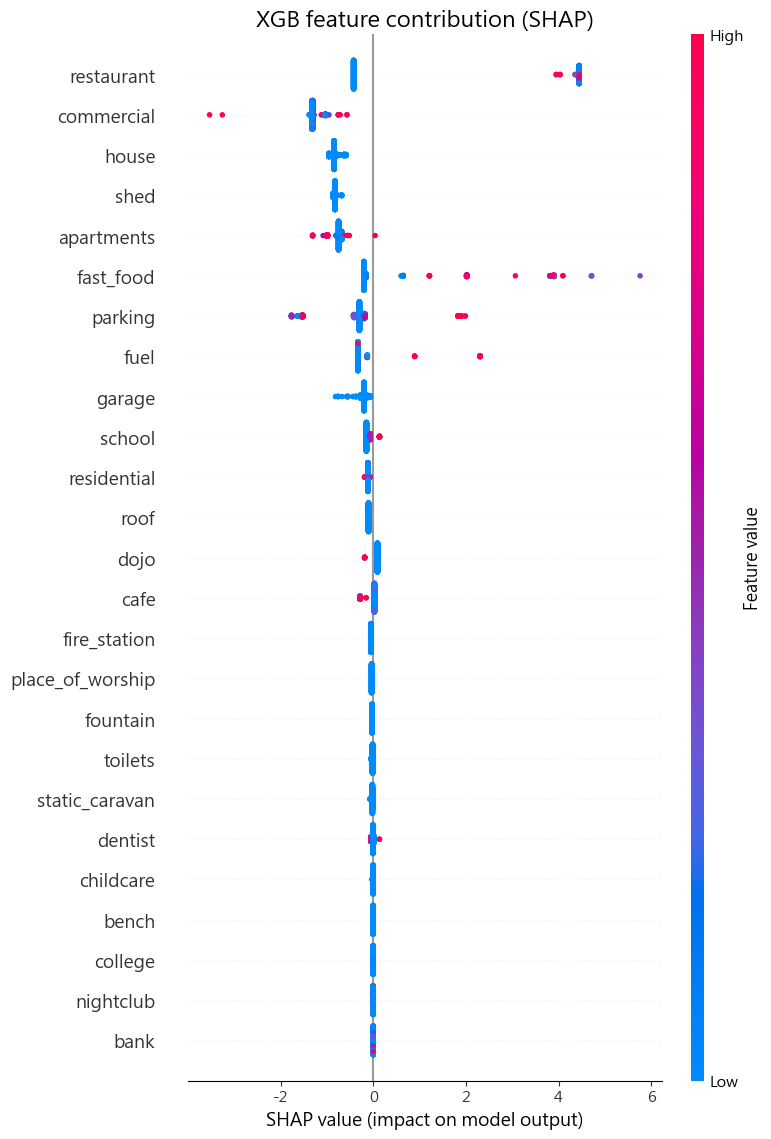

In [10]:
import shap
import matplotlib.pyplot as plt

# --- 確保您的中文字型設定 (若特徵名稱有中文需要這段) ---
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 初始化 SHAP 解釋器
explainer = shap.TreeExplainer(best_xgb_model)

# 計算 SHAP 值
# 注意：直接對 shap_values 加減數值可能會改變其「相對貢獻度」的物理意義
# 但若這是為了還原預測值的尺度，請確保邏輯符合您的需求
shap_values_test = explainer.shap_values(X_yixing_input) * ohca_range + ohca_min

feature_names = X_yixing.columns

# 建立畫布 (可以調整 figsize 來改變整體大小)
plt.figure(figsize=(10, 8)) 

# --- 關鍵修改 ---
# 1. show=False: 讓程式暫停顯示，讓我們有機會加標題
shap.summary_plot(shap_values_test, 
                  X_yixing_input, 
                  feature_names=feature_names, 
                  max_display=25, 
                  show=False) 

# 2. 加入標題 (可以調整 fontsize 大小)
plt.title("XGB feature contribution (SHAP)", fontsize=16)

# 3. 最後再顯示
plt.tight_layout()
plt.show()